# Time Series Mini Project<br>
## Forcasting Weather<br>
#### Project Goals
- Discover patterns to forecast temperature into the future
- This information could be used on future weather predictions

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Acquire<br>
- Data aquired Kaggle
- Red wine containted 645675 rows and 7 columns before cleaning

- Each row represents a date of average temperature
- Each column represents a feature associated with that date

In [2]:
def wrangle_temp_by_state():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run 
    the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'GlobalLandTemperaturesByState.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        
    return df

In [3]:
df = wrangle_temp_by_state()

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [5]:
df.shape

(645675, 5)

# Prep

In [6]:
#change data type on Date
df.dt = df.dt.astype('datetime64[ns]')

In [7]:
#set the index to Date
df = df.set_index('dt').sort_index()

In [8]:
# check head
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [9]:
#rename columns
df = df.rename(columns={'AverageTemperature':'average_temp', 
                        'AverageTemperatureUncertainty':'average_temp_uncertainty', 
                        'State':'state','Country':'country'})
    

In [10]:
# check head
df.head()

,average_temp,average_temp_uncertainty,state,country
dt,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [11]:
# rename index
df.index.names = ['date']

In [12]:
# check head
df.head()

,average_temp,average_temp_uncertainty,state,country
date,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [13]:
# check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645675 entries, 1743-11-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   average_temp              620027 non-null  float64
 1   average_temp_uncertainty  620027 non-null  float64
 2   state                     645675 non-null  object 
 3   country                   645675 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.6+ MB


In [14]:
# fill them
df = df.fillna(0)

In [15]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645675 entries, 1743-11-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   average_temp              645675 non-null  float64
 1   average_temp_uncertainty  645675 non-null  float64
 2   state                     645675 non-null  object 
 3   country                   645675 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.6+ MB


In [16]:
#create new colum for month
df['month'] = df.index.month_name()
#create new colum for weekday
df['day_of_week'] = df.index.day_name()
#create new column for year
df['year'] = df.index.year

In [17]:
# check final clean up
df.head()

,average_temp,average_temp_uncertainty,state,country,month,day_of_week,year
date,,,,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada,November,Friday,1743
1743-11-01,0.753,2.817,Michigan,United States,November,Friday,1743
1743-11-01,0.665,2.208,Prince Edward Island,Canada,November,Friday,1743
1743-11-01,-0.526,2.304,Pskov,Russia,November,Friday,1743
1743-11-01,1.891,1.718,Massachusetts,United States,November,Friday,1743


In [18]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 1743-11-01 00:00:00 to 2013-09-01 00:00:00
Shape: (645675, 7)


In [19]:
#display maximum timestamp allowed 
print(pd.Timestamp.max)

2262-04-11 23:47:16.854775807


In [20]:
# pd.set_option('display.max_rows', None)
# df.index.value_counts(ascending=False)

# Split 

In [21]:
# train test validate shapes
train_len = int(0.6 * len(df))
val_test_split = int(0.8 * len(df))
train_len, val_test_split

(387405, 516540)

In [126]:
# where train val and test begin and end along with shape
train = df.iloc[:train_len]
val = df.iloc[train_len:val_test_split]
test = df.iloc[val_test_split:]
train.shape, val.shape, test.shape

((387405, 7), (129135, 7), (129135, 7))

# Explore

In [127]:
# get distributions
def plot_distributions(df):
    for col in list(df.columns):
        plt.figure()
        sns.histplot(df[col])
        plt.title('Distribution of {}'.format(col))

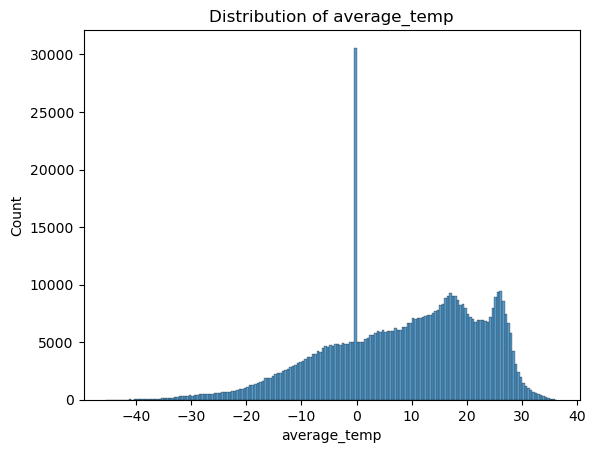

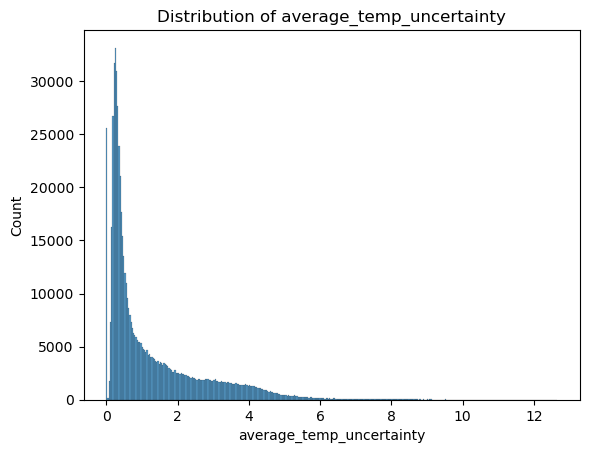

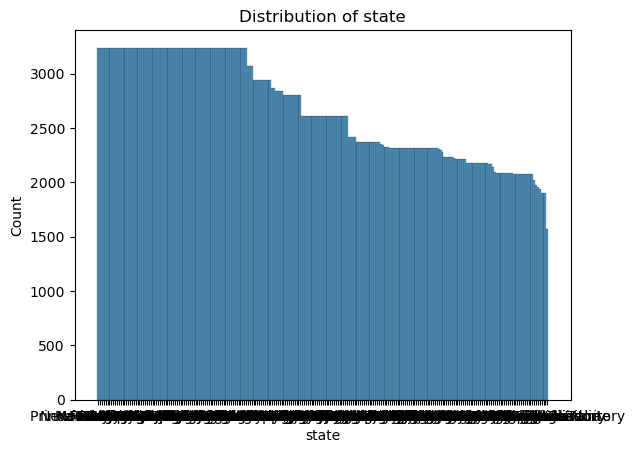

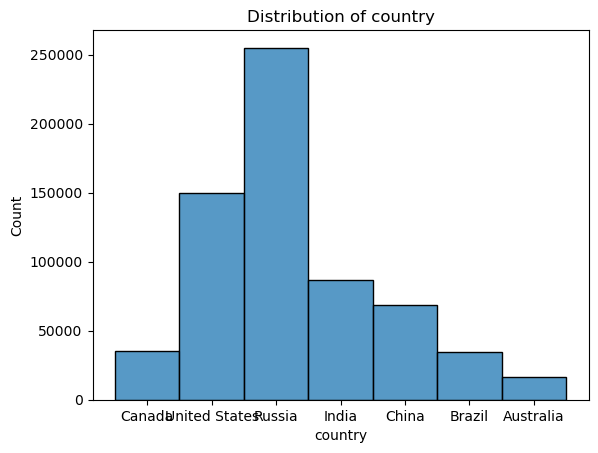

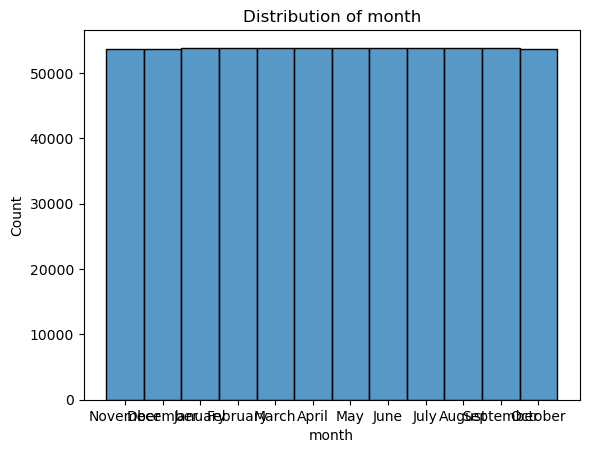

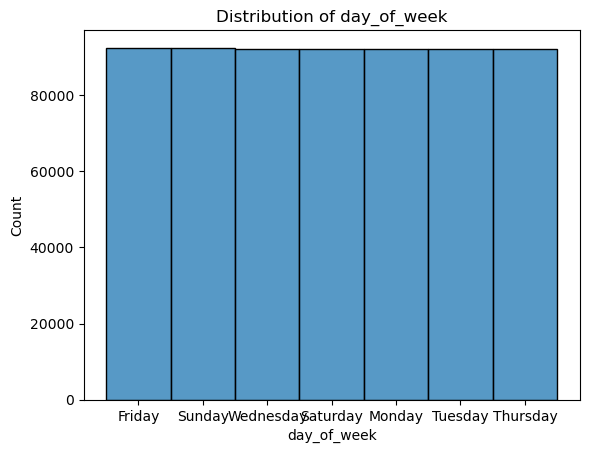

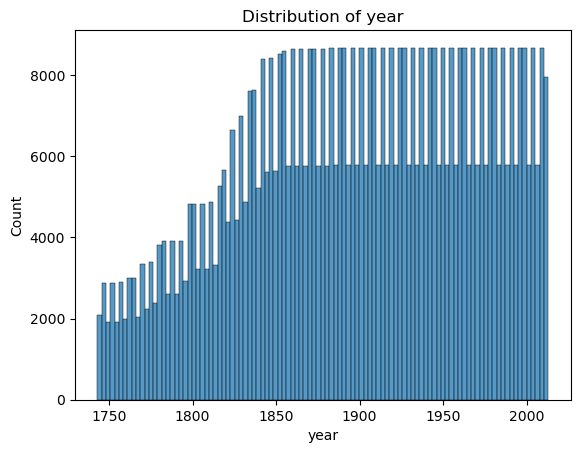

In [24]:
plot_distributions(df)

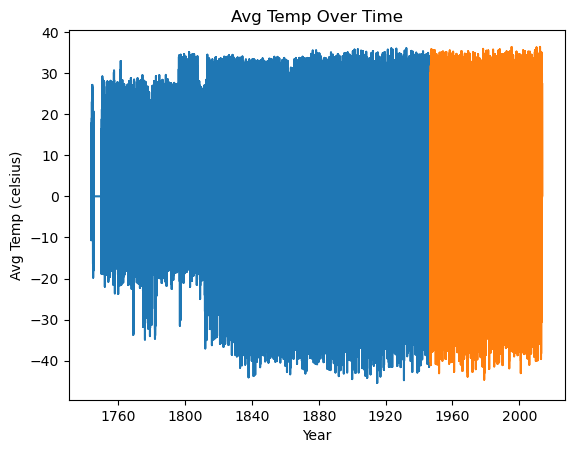

In [25]:
#plot train with target of average temp
#use percentage-based data split
train_size = .70

#n is the entire number of entries in the dataframe
n = df.shape[0]

#look at what n is (total entries in the df)
n
#set the test size to 70% * total number of entries 
test_start_index = round(train_size * n)

#take a look (70% of entire df)
test_start_index
#everything up (not including) to the test_start_index
perc_train = df[:test_start_index]

#everything from the test_start_index to the end
perc_test = df[test_start_index:] 
plt.plot(perc_train.index, perc_train.average_temp)
#plot test with target of sale amount
plt.plot(perc_test.index, perc_test.average_temp)

plt.title('Avg Temp Over Time')

plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')

None

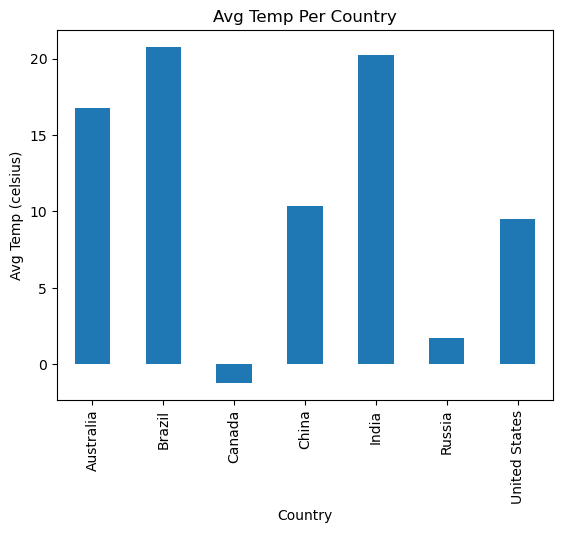

In [26]:
# plot temp per country
train.groupby('country')['average_temp'].mean().plot.bar()
plt.title('Avg Temp Per Country')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Country')
plt.show()

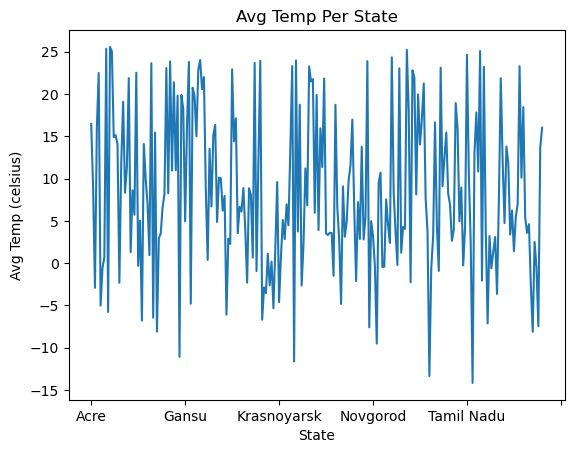

In [27]:
# plot temp by state
train.groupby('state')['average_temp'].mean().plot()
plt.title('Avg Temp Per State')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('State')
plt.show()

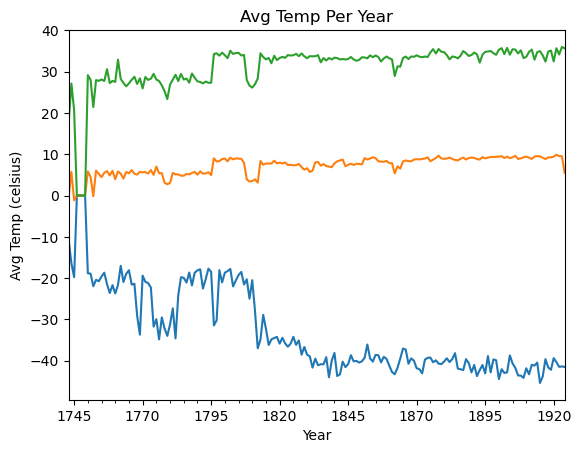

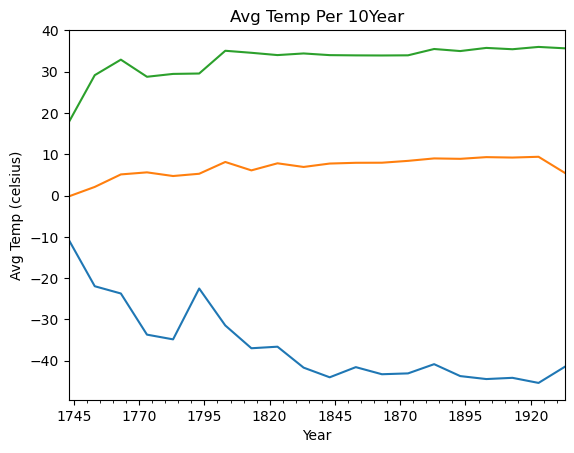

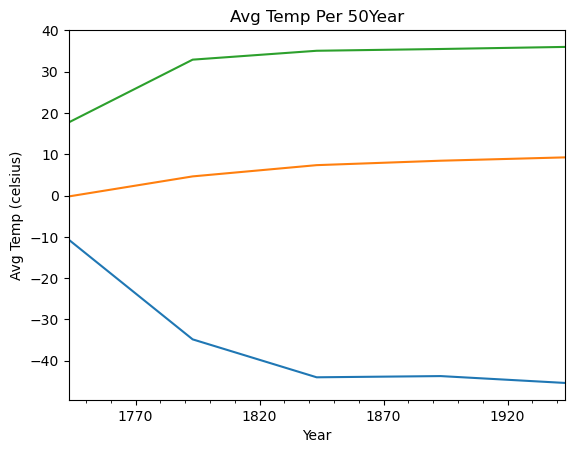

In [28]:
# resample by highest mean and lowest average temps by year
train.resample('Y').min()['average_temp'].plot()
train.resample('Y').mean()['average_temp'].plot()
train.resample('Y').max()['average_temp'].plot()
plt.title('Avg Temp Per Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()
# resample by highest mean and lowest average temps by a decade
train.resample('10Y').min()['average_temp'].plot()
train.resample('10Y').mean()['average_temp'].plot()
train.resample('10Y').max()['average_temp'].plot()
plt.title('Avg Temp Per 10Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()
# resample by highest mean and lowest average temps by half a century
train.resample('50Y').min()['average_temp'].plot()
train.resample('50Y').mean()['average_temp'].plot()
train.resample('50Y').max()['average_temp'].plot()
plt.title('Avg Temp Per 50Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()


# Model

In [29]:
# resample average temp mean by year
df_resampled = train.resample('Y')[['average_temp']].mean()
df_resampled.head()

,average_temp
date,
1743-12-31,-0.227819
1744-12-31,5.729680
1745-12-31,-1.162594
1746-12-31,0.000000
1747-12-31,0.000000


In [30]:
# new resampled df shape
df_resampled.shape

(182, 1)

In [31]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

91

In [32]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

55

In [33]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

36

In [34]:
# verify sizes match
len(df_resampled) == train_size + validate_size + test_size

True

In [35]:
# setting end of validate
validate_end_index = train_size + validate_size
validate_end_index

146

In [36]:
# setting train start point
train = df_resampled[:train_size]

In [37]:
# bottom of train
train.tail()

,average_temp
date,
1829-12-31,6.260401
1830-12-31,6.610484
1831-12-31,5.695035
1832-12-31,6.025333
1833-12-31,8.038235


In [38]:
# setting validate stopping point
validate = df_resampled[train_size:validate_end_index]

In [39]:
# top of validate
validate.head()

,average_temp
date,
1834-12-31,8.110100
1835-12-31,7.216641
1836-12-31,7.600463
1837-12-31,7.135378
1838-12-31,7.012368


In [40]:
# bottom of validate
validate.tail()

,average_temp
date,
1884-12-31,8.618476
1885-12-31,8.498805
1886-12-31,8.895175
1887-12-31,9.177548
1888-12-31,8.729320


In [41]:
# setting test start point
test = df_resampled[validate_end_index:]

In [42]:
# top of test
test.head()

,average_temp
date,
1889-12-31,9.069899
1890-12-31,9.212785
1891-12-31,9.104439
1892-12-31,8.838451
1893-12-31,8.703738


In [43]:
# checking shapes
train.shape[0], validate.shape[0], test.shape[0]

(91, 55, 36)

In [44]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [45]:
# making sure they match
print(df_resampled.head(1) == train.head(1))

            average_temp
date                    
1743-12-31          True


In [46]:
# make new df
pd.concat([test.tail(1), df_resampled.tail(1)])

,average_temp
date,
1924-12-31,5.508667
1924-12-31,5.508667


In [47]:
# train columns
train.columns

Index(['average_temp'], dtype='object')

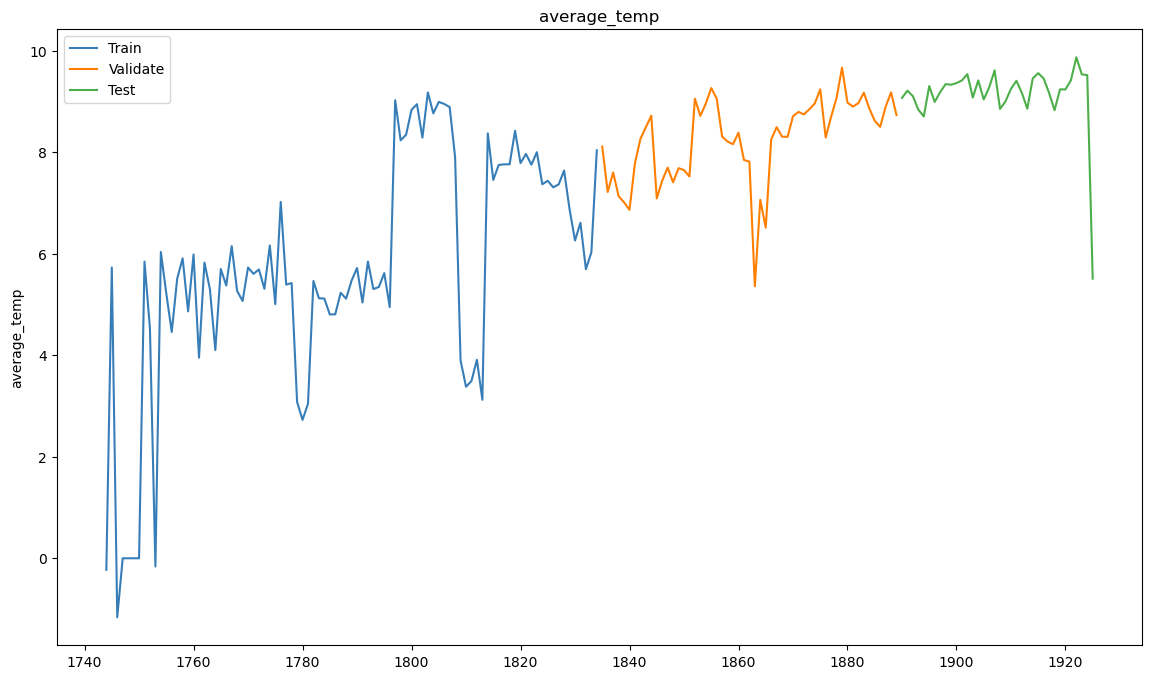

In [48]:
# for loop for average temp plot
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [49]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [50]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [51]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [52]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [53]:
train['average_temp'][-1:][0]

8.038234597156398

In [54]:
# take the last item of average temp and assign to variable
last_temp = train['average_temp'][-1:][0]

In [55]:
yhat_df = pd.DataFrame(
    {'average_temp': [last_temp],
     },
    index=validate.index)

yhat_df.head()

,average_temp
date,
1834-12-31,8.038235
1835-12-31,8.038235
1836-12-31,8.038235
1837-12-31,8.038235
1838-12-31,8.038235


In [56]:
yhat_df.describe()

,average_temp
count,5.500000e+01
mean,8.038235e+00
std,5.378187e-15
min,8.038235e+00
25%,8.038235e+00
50%,8.038235e+00
75%,8.038235e+00
max,8.038235e+00


average_temp -- RMSE: 1


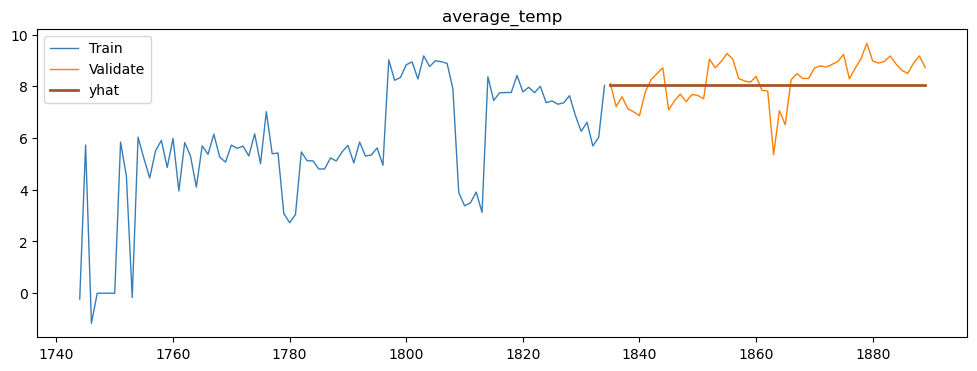

In [57]:
# average temp plot and eval function
for col in train.columns:
    plot_and_eval(col)

In [58]:
# append to eval
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0


In [59]:
# compute simple average of average temp (from train data)
avg_temp = round(train['average_temp'].mean(), 2)
avg_temp

5.67

In [60]:
def make_baseline_predictions(temp_predictions=None):
    yhat_df = pd.DataFrame({'average_temp': [temp_predictions],
                           },
                          index=validate.index)
    return yhat_df

In [61]:
yhat_df = make_baseline_predictions(avg_temp)

In [62]:
yhat_df.head()

,average_temp
date,
1834-12-31,5.67
1835-12-31,5.67
1836-12-31,5.67
1837-12-31,5.67
1838-12-31,5.67


In [63]:
yhat_df.describe()

,average_temp
count,5.500000e+01
mean,5.670000e+00
std,1.792729e-15
min,5.670000e+00
25%,5.670000e+00
50%,5.670000e+00
75%,5.670000e+00
max,5.670000e+00


In [64]:
train

,average_temp
date,
1743-12-31,-0.227819
1744-12-31,5.729680
1745-12-31,-1.162594
1746-12-31,0.000000
1747-12-31,0.000000
...,...
1829-12-31,6.260401
1830-12-31,6.610484
1831-12-31,5.695035


average_temp -- RMSE: 3


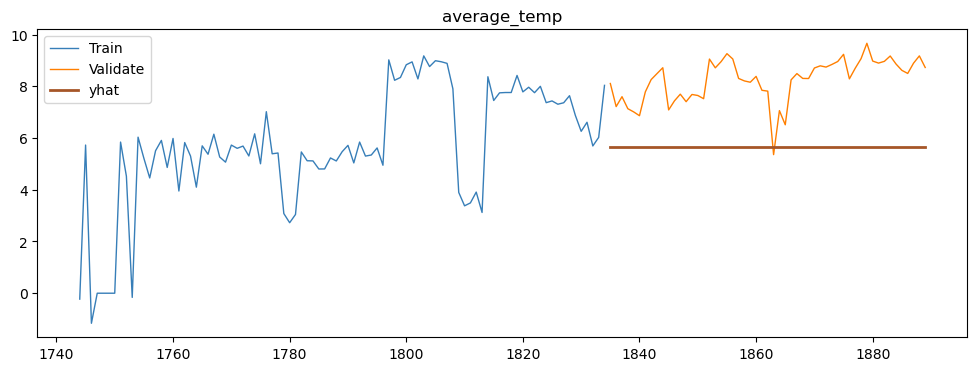

In [65]:
for col in train.columns:
    plot_and_eval(col)

In [66]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
1,simple_average,average_temp,3.0


In [67]:
period=30
train['average_temp'].rolling(period).mean()

date
1743-12-31         NaN
1744-12-31         NaN
1745-12-31         NaN
1746-12-31         NaN
1747-12-31         NaN
                ...   
1829-12-31    7.232935
1830-12-31    7.155080
1831-12-31    7.068679
1832-12-31    6.963596
1833-12-31    6.939368
Freq: A-DEC, Name: average_temp, Length: 91, dtype: float64

In [68]:
# Saving the last 30 day moving average for each column
rolling_temp = round(train['average_temp'].rolling(period).mean()[-1], 2)
print(rolling_temp)

6.94


In [69]:
yhat_df = make_baseline_predictions(rolling_temp)
yhat_df.head()

,average_temp
date,
1834-12-31,6.94
1835-12-31,6.94
1836-12-31,6.94
1837-12-31,6.94
1838-12-31,6.94


average_temp -- RMSE: 2


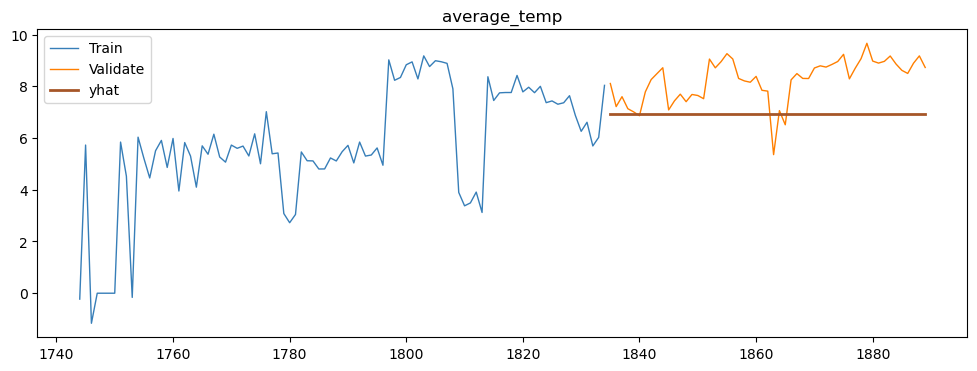

In [70]:
for col in train.columns:
    plot_and_eval(col)

In [71]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
1,simple_average,average_temp,3.0
2,30d_moving_avg,average_temp,2.0


In [72]:
periods = [4, 12, 26, 52]

for p in periods: 
    rolling_temp = round(train['average_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_temp)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [73]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
1,simple_average,average_temp,3.0
2,30d_moving_avg,average_temp,2.0
3,4_day_moving_avg,average_temp,2.0
4,12_day_moving_avg,average_temp,1.0
5,26_day_moving_avg,average_temp,2.0
6,52_day_moving_avg,average_temp,2.0


In [74]:
best_quantity_rmse = eval_df[eval_df.target_var == 'average_temp']['rmse'].min()

In [75]:
best_quantity_rmse

1.0

In [76]:
eval_df[eval_df.rmse == best_quantity_rmse]

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
4,12_day_moving_avg,average_temp,1.0


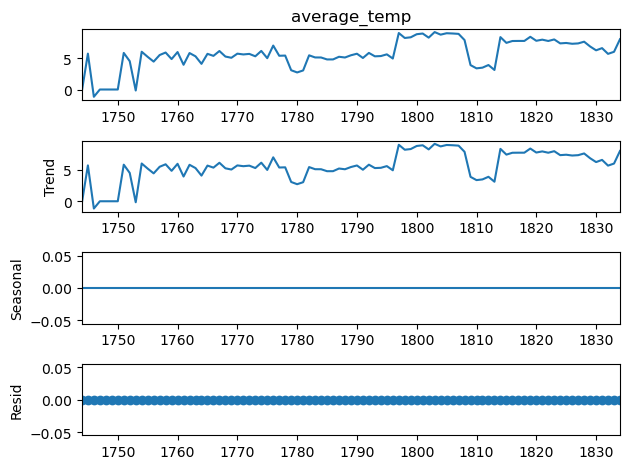

In [77]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()

In [78]:
col = 'average_temp' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [79]:
# fit the Holt object
model = model.fit(optimized=True)

In [80]:
# predict it but also give it a starting and ending point
yhat_temp_avg = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [81]:
validate.shape

(55, 1)

In [82]:
yhat_temp_avg

1834-12-31    7.017204
1835-12-31    7.020036
1836-12-31    7.022726
1837-12-31    7.025281
1838-12-31    7.027708
1839-12-31    7.030013
1840-12-31    7.032203
1841-12-31    7.034283
1842-12-31    7.036258
1843-12-31    7.038135
1844-12-31    7.039917
1845-12-31    7.041610
1846-12-31    7.043219
1847-12-31    7.044746
1848-12-31    7.046197
1849-12-31    7.047576
1850-12-31    7.048885
1851-12-31    7.050128
1852-12-31    7.051309
1853-12-31    7.052431
1854-12-31    7.053497
1855-12-31    7.054509
1856-12-31    7.055471
1857-12-31    7.056384
1858-12-31    7.057252
1859-12-31    7.058076
1860-12-31    7.058858
1861-12-31    7.059602
1862-12-31    7.060308
1863-12-31    7.060979
1864-12-31    7.061616
1865-12-31    7.062221
1866-12-31    7.062796
1867-12-31    7.063342
1868-12-31    7.063861
1869-12-31    7.064353
1870-12-31    7.064821
1871-12-31    7.065266
1872-12-31    7.065688
1873-12-31    7.066089
1874-12-31    7.066470
1875-12-31    7.066832
1876-12-31    7.067175
1877-12-31 

In [83]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [84]:
yhat_df.head()

,average_temp
date,
1834-12-31,7.02
1835-12-31,7.02
1836-12-31,7.02
1837-12-31,7.03
1838-12-31,7.03


average_temp -- RMSE: 1


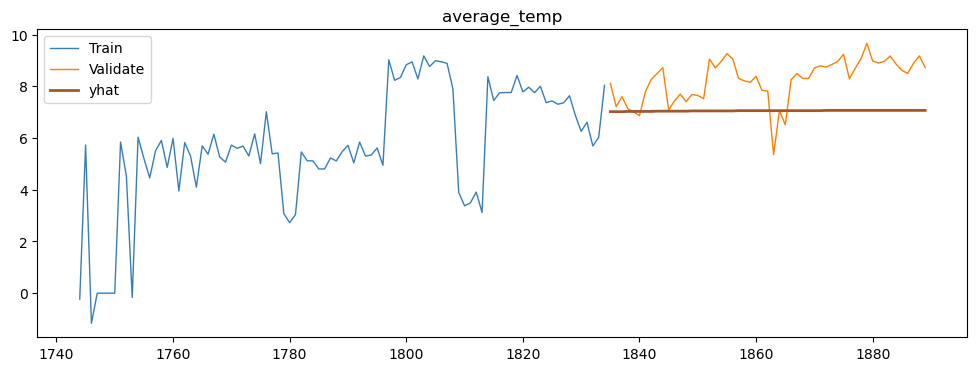

In [85]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [86]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [87]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
4,12_day_moving_avg,average_temp,1.0
7,holts_optimized,average_temp,1.0
2,30d_moving_avg,average_temp,2.0
3,4_day_moving_avg,average_temp,2.0
5,26_day_moving_avg,average_temp,2.0
6,52_day_moving_avg,average_temp,2.0
1,simple_average,average_temp,3.0


In [88]:
# Models for sales
hst_temp_fit1 = ExponentialSmoothing(train.average_temp, seasonal_periods=40, trend='add', seasonal='add').fit()
hst_temp_fit3 = ExponentialSmoothing(train.average_temp, seasonal_periods=40, trend='add', seasonal='add', damped=True).fit()

In [89]:
hst_temp_fit1.params

{'smoothing_level': 0.46899035083230745,
 'smoothing_trend': 7.27838231121548e-12,
 'smoothing_seasonal': 1.0017886501825419e-11,
 'damping_trend': nan,
 'initial_level': 1.8765641734490224,
 'initial_trend': 0.06163678914718694,
 'initial_seasons': array([-1.16369415,  0.67852952, -1.72222786, -1.23612524, -1.24526969,
        -1.44183762, -1.62670427,  0.15020454, -0.38726612, -2.08224177,
         0.60625552,  0.29949921, -0.47644957,  2.02518547,  1.76861996,
         1.23891397,  1.98320784,  0.96126061,  1.50690309,  1.6292792 ,
         0.76010399,  1.61047526,  1.36663143,  1.66135451,  0.66574505,
        -1.49764999, -1.48854802, -1.55669881, -1.36553754, -2.01244433,
         0.97833569, -0.12101871,  0.97230449,  0.10275818,  0.05629234,
        -0.84621878, -1.40284446, -1.21510878, -0.17337976, -0.28188452]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [92]:
results_average_temp=pd.DataFrame({'model':['hst_quantity_fit1','hst_quantity_fit3'],
                              'SSE':[hst_temp_fit1.sse, hst_temp_fit3.sse]})
results_average_temp

,model,SSE
0,hst_quantity_fit1,128.671199
1,hst_quantity_fit3,127.641289


In [93]:
results_average_temp.sort_values(by='SSE')

,model,SSE
1,hst_quantity_fit3,127.641289
0,hst_quantity_fit1,128.671199


In [94]:
yhat_df = pd.DataFrame({'average_temp': hst_temp_fit1.forecast(validate.shape[0]),
                        },
                          index=validate.index)
yhat_df

,average_temp
date,
1834-12-31,7.846242
1835-12-31,7.131930
1836-12-31,9.695202
1837-12-31,9.500273
1838-12-31,9.032204
1839-12-31,9.838135
1840-12-31,8.877824
1841-12-31,9.485103
1842-12-31,9.669116


average_temp -- RMSE: 2


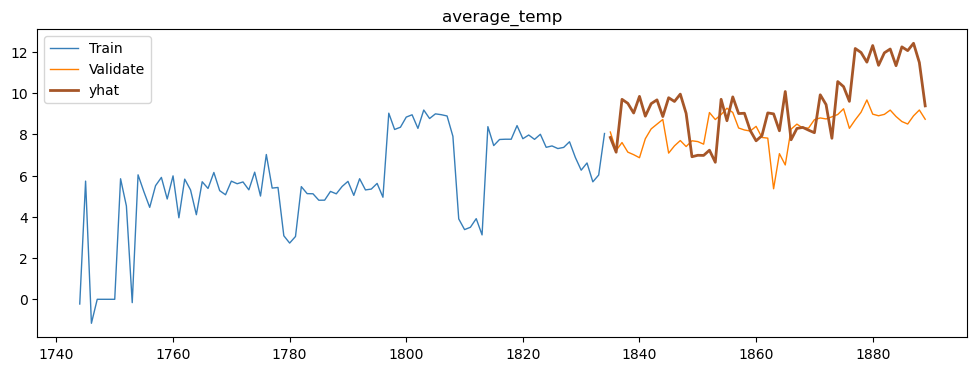

In [95]:
for col in train.columns:
    plot_and_eval(col)

In [96]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
1,simple_average,average_temp,3.0
2,30d_moving_avg,average_temp,2.0
3,4_day_moving_avg,average_temp,2.0
4,12_day_moving_avg,average_temp,1.0
5,26_day_moving_avg,average_temp,2.0
6,52_day_moving_avg,average_temp,2.0
7,holts_optimized,average_temp,1.0


In [97]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [98]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,average_temp,1.0
4,12_day_moving_avg,average_temp,1.0
7,holts_optimized,average_temp,1.0
2,30d_moving_avg,average_temp,2.0
3,4_day_moving_avg,average_temp,2.0
5,26_day_moving_avg,average_temp,2.0
6,52_day_moving_avg,average_temp,2.0
8,holts_seasonal_add_add,average_temp,2.0
1,simple_average,average_temp,3.0


# Test

In [99]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [100]:
train.shape, validate.shape, test.shape

((91, 1), (55, 1), (36, 1))

In [101]:
yhat_df = pd.DataFrame({'average_temp': hst_temp_fit1.forecast(validate.shape[0] + test.shape[0]),
                        })
yhat_df

,average_temp
1834-12-31,7.846242
1835-12-31,7.131930
1836-12-31,9.695202
1837-12-31,9.500273
1838-12-31,9.032204
...,...
1920-12-31,13.808767
1921-12-31,14.416047
1922-12-31,14.600059
1923-12-31,13.792521


In [102]:
validate.head(1)

,average_temp
date,
1834-12-31,8.1101


In [103]:
test.head(1)

,average_temp
date,
1889-12-31,9.069899


In [104]:
yhat_df = yhat_df['1889-12-31':]

In [123]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title('Model on Test')
    plt.xlabel('Date')
    plt.ylabel('Temp (celcius)')
    plt.show()

In [124]:
rmse_average_temp = sqrt(mean_squared_error(test['average_temp'], 
                                       yhat_df['average_temp']))


# TEST DATA PLOT

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-average_temp:  3.351565010098872


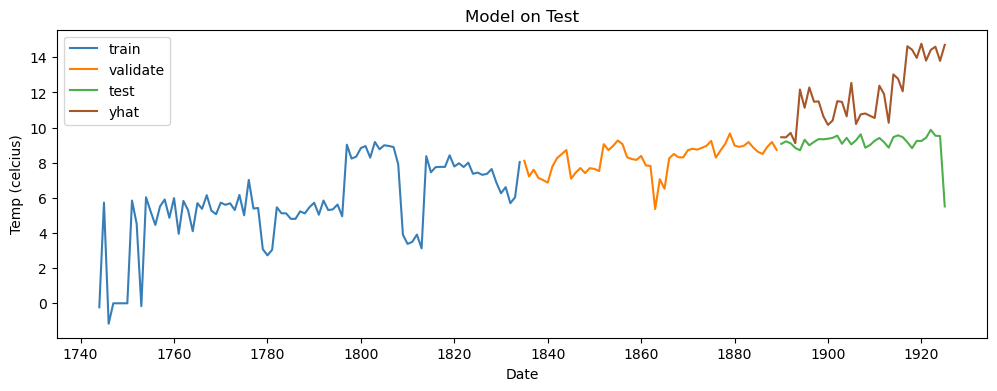

In [125]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-average_temp: ', rmse_average_temp)
for col in train.columns:
    final_plot(col)

In [108]:
forecast = pd.DataFrame({'average_temp': hst_temp_fit1.forecast(validate.shape[0] + test.shape[0] + 100),
                        })
forecast = forecast['1925':]
forecast

,average_temp
1925-12-31,14.522322
1926-12-31,14.878682
1927-12-31,13.944709
1928-12-31,11.842951
1929-12-31,11.913690
...,...
2020-12-31,17.796077
2021-12-31,18.899443
2022-12-31,18.852575
2023-12-31,18.032402


# FORCAST PLOT

In [117]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title('Average Temp Forcast')
    plt.xlabel('Date')
    plt.ylabel('Temp (Celcius)')
    plt.legend()
    plt.show()

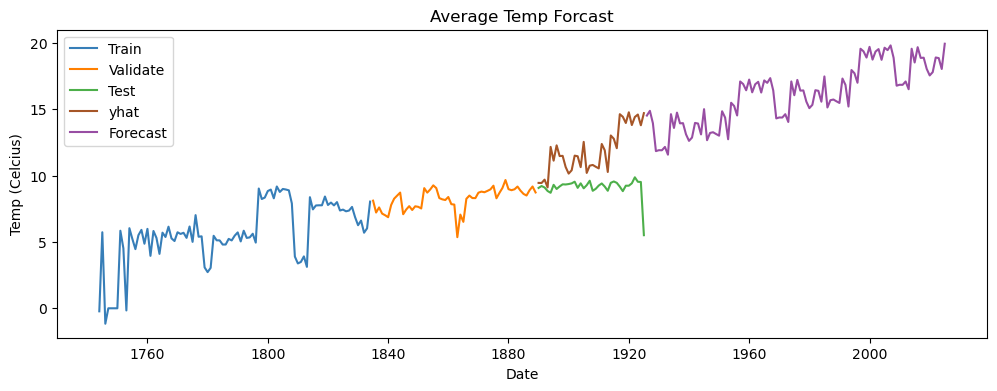

In [116]:
for col in train.columns:
    final_plot(col)